# LIC BID Intervention Mutli-Criteria Decision Tool

In [190]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import box, Polygon, Point
from shapely import wkt

import contextily as cx

In [305]:
def load_data_and_create_geodataframe(file_path):
    """
    Load data from a CSV file and create a GeoDataFrame, handling either WKT geometry columns
    or Latitude/Longitude coordinate columns.
    
    Parameters:
    -----------
    file_path : str
        Path to the CSV file
    
    Returns:
    --------
    GeoDataFrame
        GeoDataFrame with proper geometry
    """
    # Load data
    df = pd.read_csv(file_path)
    print(f"  Loaded df with {len(df)} rows")

    # Check available columns
    print("  Available columns:", df.columns.tolist())
    
    # Check if we have latitude and longitude columns
    lat_candidates = ['latitude', 'lat', 'y', 'ylat', 'point_y']
    lon_candidates = ['longitude', 'lon', 'long', 'x', 'xlong', 'point_x']
    
    lat_col = None
    lon_col = None
    
    # Find the latitude column (case insensitive)
    for col in df.columns:
        if col.lower() in lat_candidates:
            lat_col = col
            print(f"  Found latitude column: {col}")
            break
    
    # Find the longitude column (case insensitive)
    for col in df.columns:
        if col.lower() in lon_candidates:
            lon_col = col
            print(f"  Found longitude column: {col}")
            break
    
    # If we have lat/lon columns, create points from them
    if lat_col and lon_col:
        print("  Creating geometry from latitude and longitude columns...")
        try:
            # Create a list of Point geometries
            from shapely.geometry import Point
            geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
            
            # Create GeoDataFrame
            data = gpd.GeoDataFrame(df, geometry=geometry)
            
            # Set CRS to WGS84 (standard for lat/lon)
            data.crs = "EPSG:4326"
            print("  Successfully created GeoDataFrame from lat/lon columns")
            return data
        except Exception as e:
            print(f"  Error creating geometry from lat/lon: {e}")
            print("  Attempting to find WKT geometry column instead...")
    
    # If lat/lon approach failed or wasn't available, try WKT geometry
    # Look for geometry column
    geometry_column = None
    for col in ['the_geom', 'wkt_geom', 'geometry', 'geom', 'shape', 'Georeference', 'WktGeom']:
        if col in df.columns:
            geometry_column = col
            print(f"  Found potential geometry column: {col}")
            break

    if not geometry_column:
        raise ValueError("No geometry column or lat/lon columns found in data")

    # Try to convert to GeoDataFrame
    print("  Converting geometry column to GeoSeries...")
    try:
        # Verify the column has valid data
        print(f"  Sample geometry value: {df[geometry_column].iloc[0][:100]}...")
        
        # Try to convert to geometry
        geometry = gpd.GeoSeries.from_wkt(df[geometry_column])
        
        # Create GeoDataFrame using the geometry
        data = gpd.GeoDataFrame(df, geometry=geometry)
        
        # Set CRS if needed (assuming WGS84)
        data.crs = "EPSG:4326"
        print("  Successfully created GeoDataFrame from WKT")
    except Exception as e:
        print(f"  Error converting geometry: {e}")
        # Try alternative approach - check first few values
        print("  Attempting manual conversion...")
        
        # Create empty list for geometries
        geometries = []
        
        # Loop through each row
        for i, row in df.iterrows():
            try:
                from shapely import wkt
                geom = wkt.loads(row[geometry_column])
                geometries.append(geom)
            except Exception as e:
                print(f"  Error on row {i}: {e}")
                # Add a placeholder geometry to maintain index alignment
                geometries.append(Point(0, 0))
        
        # Create GeoDataFrame with the geometries
        data = gpd.GeoDataFrame(df, geometry=geometries)
        data.crs = "EPSG:4326"
        print("  Created GeoDataFrame using manual conversion")
    
    return data

## LIC BID Data

### 1. Loading the BID data...

In [219]:
bid_data = load_data_and_create_geodatafream('DATA/NYC_BIDS_09112015.csv')

  Loaded df with 76 rows
  Available columns: ['the_geom', 'Id', 'OBJECTID_1', 'OBJECTID_2', 'Shape_Leng', 'F_ALL_BIDs', 'F_ALL_BI_1', 'F_ALL_BI_2', 'F_ALL_BI_3', 'F_ALL_BI_4', 'F_ALL_BI_6', 'F_ALL_BI_7', 'Shape_Le_1', 'Shape_Ar_1', 'Year_Found', 'Shape_Area']
  Found potential geometry column: the_geom
  Converting geometry column to GeoSeries...
  Sample geometry value: MULTIPOLYGON (((-73.94296015325146 40.739491660153085, -73.94304297671536 40.739240888182785, -73.94...
  Successfully created GeoDataFrame


### 2. Filtering for Long Island City BID..

In [193]:
# Filter for Long Island City Partnership
lic_data = bid_data[bid_data['F_ALL_BI_2'] == "Long Island City Partnership"]
if len(lic_data) == 0:
    raise ValueError("Long Island City Partnership not found in BID data")
print(f"  Found {len(lic_data)} rows for Long Island City Partnership")


  Found 1 rows for Long Island City Partnership


### 3. Processing the LIC BID geometry...

In [194]:
# Ensure we have valid geometries
print(f"  LIC data has geometry type: {lic_data.geometry.geom_type.unique()}")

# Explode multi-part geometries if needed
if 'MultiPolygon' in lic_data.geometry.geom_type.unique():
    lic_data_exploded = lic_data.explode(index_parts=True)
    print(f"  Exploded geometries: Original {len(lic_data)}, After explode {len(lic_data_exploded)}")
else:
    lic_data_exploded = lic_data
    print("  No multi-part geometries to explode")

  LIC data has geometry type: ['MultiPolygon']
  Exploded geometries: Original 1, After explode 154


### 4. Separate the south expansion area

In [195]:
# Load your context area from the saved GeoJSON
context_area = gpd.read_file('DATA/LIC_South_Expansion.geojson')
context_area.crs = "EPSG:4326"

lic_south_data_exploded = gpd.clip(lic_data_exploded, context_area)

# Create unified boundary
lic_boundary = lic_data_exploded.unary_union
print(f"  Created unified LIC boundary of type: {lic_boundary.geom_type}")

# Create unified boundary
lic_south_boundary = lic_south_data_exploded.unary_union
print(f"  Created unified LIC boundary of type: {lic_south_boundary.geom_type}")

  Created unified LIC boundary of type: MultiPolygon
  Created unified LIC boundary of type: MultiPolygon


/var/folders/py/bm4kf8_j7tn54t9vvg2pyb5r0000gn/T/ipykernel_48460/1805371416.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  lic_boundary = lic_data_exploded.unary_union
/var/folders/py/bm4kf8_j7tn54t9vvg2pyb5r0000gn/T/ipykernel_48460/1805371416.py:12: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  lic_south_boundary = lic_south_data_exploded.unary_union


## Street Pavement Rating 
https://data.cityofnewyork.us/Transportation/Street-Pavement-Rating/6yyb-pb25/about_data 

In [196]:
street_data = load_data_and_create_geodatafream('DATA/Street_Pavement_Rating_20250421.csv')

/var/folders/py/bm4kf8_j7tn54t9vvg2pyb5r0000gn/T/ipykernel_48460/4269641349.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


  Loaded df with 132542 rows
  Available columns: ['the_geom', 'SegmentID', 'BoroughCod', 'OFTCode', 'OnStreetNa', 'FromStreet', 'ToStreetNa', 'WKT', 'ManualRati', 'RatingLaye', 'Inspection', 'Shape_STLe']
  Found potential geometry column: the_geom
  Converting geometry column to GeoSeries...
  Sample geometry value: MULTILINESTRING ((-73.97000244691225 40.67263115006847, -73.9696639405562 40.672642367278115))...
  Successfully created GeoDataFrame


In [197]:
# Then filter using cx
xmin, ymin, xmax, ymax = lic_data_exploded.total_bounds
lic_street_data = street_data.cx[xmin:xmax, ymin:ymax]

print(f"Found {len(lic_street_data)} street segments within the bounding box")

# For south expansion area
lic_south_street_data = gpd.clip(street_data, context_area)

print(f"  Found {len(lic_south_street_data)} streets within LIC boundary")

Found 1149 street segments within the bounding box
  Found 343 streets within LIC boundary


In [207]:
lic_street_data.to_file("EXPORT/pavement_ratings.geojson")

## NYC Planimetric Database - Parking Lot
https://data.cityofnewyork.us/City-Government/NYC-Planimetric-Database-Parking-Lot/h7zy-iq3d

In [198]:
parking_data = load_data_and_create_geodatafream('DATA/NYC_Planimetric_Database__Parking_Lot_20250421.csv')

  Loaded df with 20429 rows
  Available columns: ['the_geom', 'SOURCE_ID', 'FEAT_CODE', 'SUB_CODE', 'STATUS', 'SHAPE_Leng', 'SHAPE_Area']
  Found potential geometry column: the_geom
  Converting geometry column to GeoSeries...
  Sample geometry value: MULTIPOLYGON (((-74.23300207444957 40.54360328370629, -74.23311104917609 40.54341991363297, -74.2331...
  Successfully created GeoDataFrame


In [ ]:
# Filter using intersection with LIC boundary
lic_parking_data = parking_data[parking_data.intersects(lic_south_boundary)]
print(f"  Found {len(lic_parking_data)} parking lots within LIC boundary")


  Found 54 parking lots within LIC boundary


In [ ]:
# Export the filtered data
lic_parking_data.to_file("EXPORT/parking_lots.geojson")

## Housing Database
https://data.cityofnewyork.us/Housing-Development/Housing-Database/6umk-irkx/about_data 

In [264]:
housing_data = load_data_and_create_geodataframe("DATA/nychdb_24q4_csv/HousingDB_post2010.csv")

housing_data = housing_data[(housing_data['Job_Status'] == '5. Completed Construction')
                                     & (housing_data['CDTA2020'].isin(['QN02', 'QN01']))]
housing_data = housing_data[['geometry', 'Units_CO']]

housing_data.to_file("EXPORT/population.geojson")

/var/folders/py/bm4kf8_j7tn54t9vvg2pyb5r0000gn/T/ipykernel_48460/4144026614.py:17: DtypeWarning: Columns (0,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


  Loaded df with 77845 rows
  Available columns: ['Job_Number', 'Job_Type', 'ResidFlag', 'NonresFlag', 'Job_Status', 'CompltYear', 'PermitYear', 'ClassAInit', 'ClassAProp', 'ClassANet', 'HotelInit', 'HotelProp', 'OtherBInit', 'OtherBProp', 'Units_CO', 'Boro', 'BIN', 'BBL', 'AddressNum', 'AddressSt', 'Occ_Init', 'Occ_Prop', 'Bldg_Class', 'Job_Desc', 'DateFiled', 'DatePermit', 'DateLstUpd', 'DateComplt', 'ZoningDst1', 'ZoningDst2', 'ZoningDst3', 'SpeclDst1', 'SpeclDst2', 'Landmark', 'FloorsInit', 'FloorsProp', 'Enlargemnt', 'Ownership', 'CenBlock20', 'CenTract20', 'BCTCB2020', 'BCT2020', 'NTA2020', 'NTAName20', 'CDTA2020', 'CDTAName20', 'CommntyDst', 'CouncilDst', 'SchSubDist', 'SchCommnty', 'SchElmntry', 'SchMiddle', 'FireCmpany', 'FireBattln', 'FireDivsn', 'PolicePcnt', 'PL_FIRM07', 'PL_PFIRM15', 'Latitude', 'Longitude', 'GeomSource', 'DCPEdited', 'Version']
  Found latitude column: Latitude
  Found longitude column: Longitude
  Creating geometry from latitude and longitude columns...


## Subway Entrances
https://catalog.data.gov/dataset/mta-subway-stations

In [269]:
subway_data = load_data_and_create_geodataframe("DATA/MTA_Subway_Stations.csv")

  Loaded df with 496 rows
  Available columns: ['GTFS Stop ID', 'Station ID', 'Complex ID', 'Division', 'Line', 'Stop Name', 'Borough', 'CBD', 'Daytime Routes', 'Structure', 'GTFS Latitude', 'GTFS Longitude', 'North Direction Label', 'South Direction Label', 'ADA', 'ADA Northbound', 'ADA Southbound', 'ADA Notes', 'Georeference']
  Found potential geometry column: Georeference
  Converting geometry column to GeoSeries...
  Sample geometry value: POINT (-73.987495 40.75529)...
  Successfully created GeoDataFrame from WKT


In [ ]:
# Then filter using cx
xmin, ymin, xmax, ymax = lic_data_exploded.total_bounds
lic_subway_data = subway_data.cx[xmin:xmax, ymin:ymax]

print(f"Found {len(lic_subway_data)} subway entrances within the bounding box")

Found 12 street segments within the bounding box


In [279]:
lic_subway_data.to_file("EXPORT/subway_entrances.geojson")

## Citibike Station

In [292]:
import requests

# Fetch station information (contains locations)
station_info_url = "https://gbfs.citibikenyc.com/gbfs/en/station_information.json"
station_info_response = requests.get(station_info_url)
station_info_data = station_info_response.json()

# Check the structure of the response
print("Data structure:", station_info_data.keys())
print("Data inside 'data':", station_info_data['data'].keys())
print(f"Number of stations: {len(station_info_data['data']['stations'])}")

# Create a DataFrame from the stations list
stations_df = pd.DataFrame(station_info_data['data']['stations'])

Data structure: dict_keys(['data', 'last_updated', 'ttl', 'version'])
Data inside 'data': dict_keys(['stations'])
Number of stations: 2233


In [286]:
# Extract latitude and longitude
# Create a list of Point geometries
geometry = [Point(xy) for xy in zip(stations_df['lon'], stations_df['lat'])]

# Create GeoDataFrame
bike_stations_data = gpd.GeoDataFrame(stations_df, geometry=geometry)

# Set CRS to WGS84 (standard for lat/lon)
bike_stations_data.crs = "EPSG:4326"

print(f"Created GeoDataFrame with {len(bike_stations_data)} stations")

Created GeoDataFrame with 2233 stations


In [ ]:
# Filter stations to those within the context area
# Ensure both GeoDataFrames have the same CRS
if bike_stations_data.crs != context_area.crs:
    bike_stations_data = bike_stations_data.to_crs(context_area.crs)

# Use spatial join to find stations within the context area
lic_bike_stations_data = gpd.sjoin(bike_stations_data, context_area, predicate='within')

print(f"Found {len(lic_bike_stations_data)} stations within the LIC area")

Found 17 stations within the LIC area


In [291]:
lic_bike_stations_data.to_file("EXPORT/citibike_stations.geojson")

## Bike Routes
https://data.cityofnewyork.us/dataset/New-York-City-Bike-Routes-Map-/9e2b-mctv 

In [293]:
bike_routes_data = load_data_and_create_geodataframe("DATA/New_York_City_Bike_Routes_20250421.csv")

  Loaded df with 27673 rows
  Available columns: ['the_geom', 'segmentid', 'version', 'bikeid', 'prevbikeid', 'status', 'boro', 'street', 'fromstreet', 'tostreet', 'onoffst', 'facilitycl', 'allclasses', 'bikedir', 'lanecount', 'ft_facilit', 'tf_facilit', 'ft2facilit', 'tf2facilit', 'instdate', 'ret_date', 'Shape_Leng']
  Found potential geometry column: the_geom
  Converting geometry column to GeoSeries...
  Sample geometry value: MULTILINESTRING ((-74.192429667502 40.521741493622734, -74.1951900846669 40.519998791664904))...
  Successfully created GeoDataFrame from WKT


In [294]:
# For south expansion area
lic_south_bike_routes_data = gpd.clip(bike_routes_data, context_area)

print(f"  Found {len(lic_south_bike_routes_data)} streets within LIC boundary")

  Found 76 streets within LIC boundary


In [296]:
lic_south_bike_routes_data.to_file("EXPORT/bike_lanes.geojson")

## Traffic Flow

https://data.cityofnewyork.us/Transportation/Automated-Traffic-Volume-Counts/7ym2-wayt/about_data

In [ ]:
# Load data
traffic_data = load_data_and_create_geodataframe("DATA/Automated_Traffic_Volume_Counts_20250422.csv")

# Reproject CRS
traffic_data.crs = "EPSG:2263"
traffic_data = traffic_data.to_crs("EPSG:4326")
traffic_data

  Loaded df with 393 rows
  Available columns: ['SegmentID', 'M', 'Yr', 'D', 'WktGeom', 'street', 'Vol', 'fromSt', 'toSt']
  Found potential geometry column: WktGeom
  Converting geometry column to GeoSeries...
  Sample geometry value: POINT (1013843.067320377 189249.1128744095)...
  Successfully created GeoDataFrame from WKT


,SegmentID,M,Yr,D,WktGeom,street,Vol,fromSt,toSt,geometry
0,141367,4,2023,4,POINT (1013843.067320377 189249.1128744095),JACKIE ROBINSON PARKWAY,40315,Dead end,Dead End,POINT (-73.8933 40.68607)
1,156596,5,2022,17,POINT (1023913.269033063 183538.80365108862),LINDEN BOULEVARD,13682,Dead End,79 Street,POINT (-73.85702 40.67036)
2,77104,5,2022,19,POINT (1015029.50289154 223906.76034060976),RIKERS ISLAND BRIDGE,5334,Rikers Is Bridge,Dead end,POINT (-73.88886 40.78119)
3,113038,9,2023,18,POINT (1009106.1610914068 213482.47529988937),WOODSIDE AVENUE,3727,Dead End,37 Avenue,POINT (-73.91029 40.7526)
4,68884,8,2023,12,POINT (1007201.1820997201 223539.69446798888),21 STREET,6172,Ditmars Boulevard,22 Road,POINT (-73.91713 40.78021)
...,...,...,...,...,...,...,...,...,...,...
388,65967,6,2022,28,POINT (1000731.5336691153 209191.80335594836),HUNTERS POINT BRIDGE,113,Dead End,Dutch Kills Shoreline,POINT (-73.94052 40.74084)
389,138541,2,2022,12,POINT (1020219.1153209634 219414.53589356926),23 AVENUE,2362,101 Street,100 Street,POINT (-73.87014 40.76885)
390,77104,7,2023,5,POINT (1015029.50289154 223906.76034060976),RIKERS ISLAND BRIDGE,5806,Rikers Is Bridge,Dead end,POINT (-73.88886 40.78119)
391,177615,5,2022,13,POINT (1028931.8143046284 215115.26618027306),ROOSEVELT AVENUE BRIDGE,19228,Flushing Line,Flushing Line,POINT (-73.83872 40.75701)


In [366]:
# First, ensure Vol is numeric
traffic_data['Vol'] = pd.to_numeric(traffic_data['Vol'], errors='coerce')

# Create a date column for better grouping
traffic_data['date'] = pd.to_datetime(
    traffic_data['Yr'].astype(str) + '-' + 
    traffic_data['M'].astype(str) + '-' + 
    traffic_data['D'].astype(str)
)

# Make sure both datasets have the same CRS
if traffic_data.crs != context_area.crs:
    traffic_data = traffic_data.to_crs(context_area.crs)

# Spatial join to find segments within the context area
traffic_in_context = gpd.sjoin(traffic_data, context_area, predicate='within')
print(f"Filtered from {len(traffic_data)} to {len(traffic_in_context)} points within context area")

# Calculate daily average volume by SegmentID for points within context area
traffic_data_agg = traffic_in_context.groupby(['SegmentID', 'date'])['Vol'].mean().reset_index()
traffic_data_agg.rename(columns={'Vol': 'avg_daily_vol'}, inplace=True)

# Calculate overall average by SegmentID
segment_avg = traffic_data_agg.groupby('SegmentID')['avg_daily_vol'].mean().reset_index()
segment_avg = segment_avg.sort_values('avg_daily_vol', ascending=False)

# Display the top 10 segments by traffic volume
print("Top 10 segments by average daily traffic volume in LIC South Expansion:")
print(segment_avg.head(10))

# Merge back with original data to get segment locations for visualization
# Create a dataframe with unique SegmentIDs and their geometries
segment_locations = traffic_in_context[['SegmentID', 'geometry', 'street']].drop_duplicates(subset=['SegmentID'])

# Merge the averages with locations
segment_avg_with_loc = segment_avg.merge(segment_locations, on='SegmentID')

# Merge the vol with street line
segment_avg_with_loc = segment_avg_with_loc.merge(lic_street_data[['SegmentID', 'geometry']], on='SegmentID', how='left')
segment_avg_with_loc['geometry'] = segment_avg_with_loc['geometry_y']
segment_avg_with_loc.drop(columns=['geometry_x', 'geometry_y'], inplace=True)

# Convert back to GeoDataFrame
lic_traffic_data = gpd.GeoDataFrame(segment_avg_with_loc, geometry='geometry', crs=traffic_data.crs)


Filtered from 393 to 43 points within context area
Top 10 segments by average daily traffic volume in LIC South Expansion:
   SegmentID  avg_daily_vol
2     189271   12808.777778
1      66081    6847.571429
0      65967     766.333333


In [367]:
lic_traffic_data.to_file("EXPORT/traffic_flow.geojson")

## POI data

In [ ]:
poi_data = load_data_and_create_geodataframe('DATA/Points_of_Interest_20250325.csv')

  Loaded df with 20600 rows
  Available columns: ['the_geom', 'SEGMENTID', 'COMPLEXID', 'SAFTYPE', 'SOS', 'PLACEID', 'FACI_DOM', 'BIN', 'BOROUGH', 'CREATED', 'MODIFIED', 'FACILITY_T', 'SOURCE', 'B7SC', 'PRI_ADD', 'NAME']
  Found potential geometry column: the_geom
  Converting geometry column to GeoSeries...
  Sample geometry value: POINT (-74.00701717096757 40.724634757833414)...
  Successfully created GeoDataFrame from WKT


In [377]:
# Filter stations to those within the context area
# Ensure both GeoDataFrames have the same CRS
if poi_data.crs != context_area.crs:
    poi_data = poi_data.to_crs(context_area.crs)

# Use spatial join to find stations within the context area
lic_poi_data = gpd.sjoin(poi_data, context_area, predicate='within')

print(f"Found {len(lic_poi_data)} POIs within the LIC area")

Found 39 POIs within the LIC area


In [383]:
lic_poi_data.to_file('EXPORT/poi.geojson')

## Visualization

In [326]:
# Calculate buffer around LIC boundary to create focused view
buffer_distance = 0.005  # Adjust this value as needed to zoom in appropriately

# Get the bounds of the LIC area with buffer
if isinstance(lic_boundary, Polygon) or hasattr(lic_boundary, 'bounds'):
    minx, miny, maxx, maxy = lic_boundary.bounds
else:
    minx, miny, maxx, maxy = lic_boundary.total_bounds

# Add buffer to create context area
minx -= buffer_distance
miny -= buffer_distance
maxx += buffer_distance
maxy += buffer_distance

/var/folders/py/bm4kf8_j7tn54t9vvg2pyb5r0000gn/T/ipykernel_48460/2930297995.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


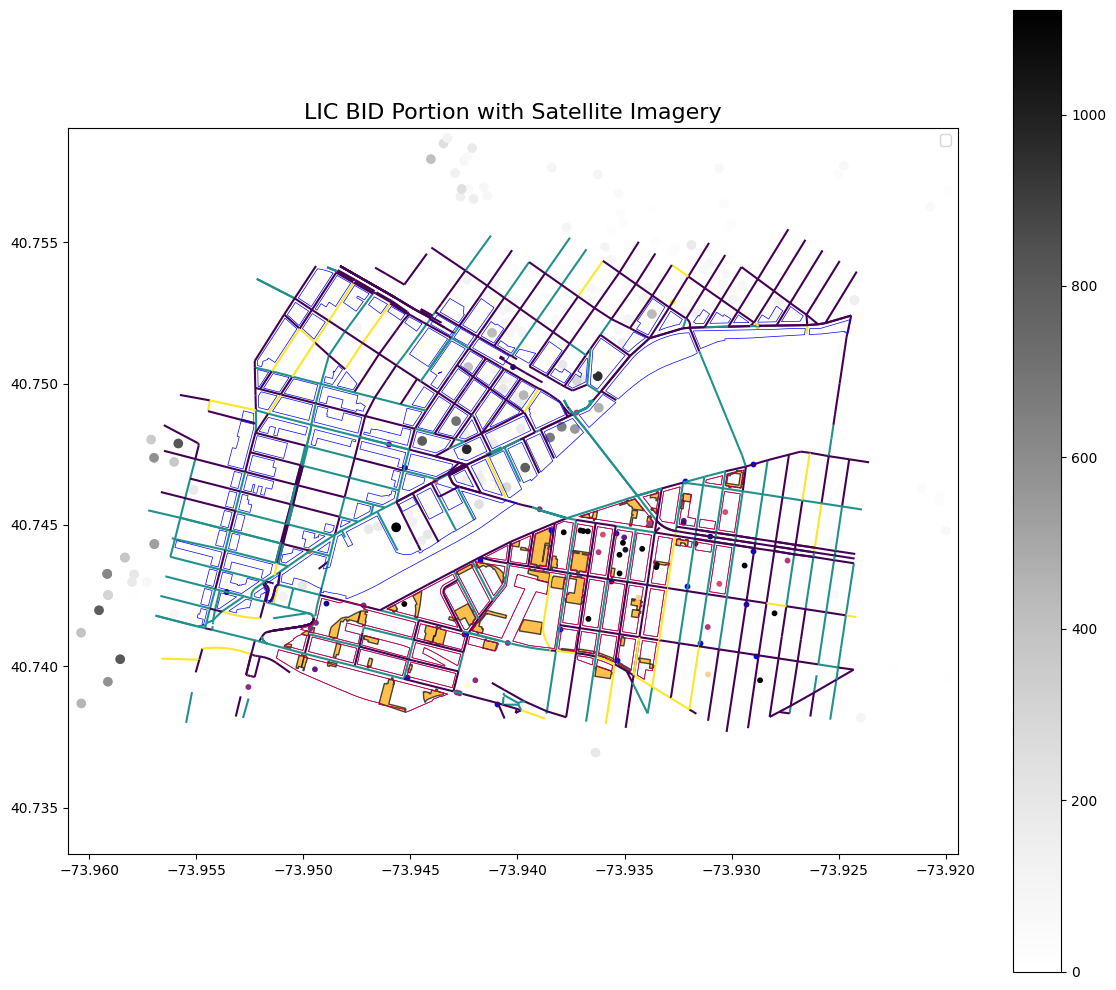

In [381]:
# Create visualization focused only on the context area
fig, ax = plt.subplots(figsize=(12, 10))

# Set the plot limits to focus on just the context area
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot the context area steet ratings
lic_parking_data.plot(ax=ax, color='orange', alpha=0.7, edgecolor='black')

# Plot the context area parking lots
lic_street_data.plot(ax=ax, column='RatingLaye', linewidth=1.5, 
                     cmap='viridis', legend=True)
# lic_traffic_data.plot(ax=ax, column='avg_daily_vol', linewidth=1.5, 
                    #  cmap='viridis', legend=True)

# Plot surrounding residents
housing_data.plot(ax=ax, column='Units_CO', cmap='Greys', legend=True)

# Plot subway stations
lic_subway_data.plot(ax=ax, markersize=10, column='Daytime Routes', cmap='plasma')

# Plot bike stations
lic_bike_stations_data.plot(ax=ax, markersize=10, color='blue')

# Plot POIs
lic_poi_data.plot(ax=ax, markersize=10, column='FACILITY_T', cmap='magma')

# Plot LIC boundary
lic_data_exploded.boundary.plot(ax=ax, color='blue', linewidth=0.5)
lic_south_data_exploded.boundary.plot(ax=ax, color='red', linewidth=0.5)

# Plot traffic flow

# Add a title
plt.title("Parking Lots within Long Island City BID - Context Area View", fontsize=16)

# Add a north arrow and scale bar if you want more map elements

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='orange', edgecolor='black', alpha=0.7, label='Parking Lots in LIC BID'),
    Patch(facecolor='lightgray', edgecolor='darkgray', alpha=0.3, label='Other Parking Lots'),
    Patch(facecolor='none', edgecolor='blue', linewidth=1, label='LIC BID Boundary')
]
ax.legend(handles=legend_elements, loc='upper right')

# Add title and legend
plt.title("LIC BID Portion with Satellite Imagery", fontsize=16)
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig("LIC_Parking_Lots_Context.png", dpi=300)
plt.show()

In [274]:
import folium

# Create a map centered on the context area
center = context_area.to_crs(epsg=4326).centroid.iloc[0]
m = folium.Map(location=[center.y, center.x], zoom_start=15, tiles='OpenStreetMap')

# Add satellite layer
folium.TileLayer('https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                attr='Esri', name='Esri Satellite', overlay=False).add_to(m)

# Add the GeoDataFrames
folium.GeoJson(lic_boundary.__geo_interface__, 
               name='Original LIC BID',
               style_function=lambda x: {'color': 'blue', 'weight': 2, 'fillOpacity': 0}).add_to(m)

folium.GeoJson(lic_parking_data.__geo_interface__, 
               name='Parking Lots',
               style_function=lambda x: {'color': 'red', 'weight': 2.5, 'fillOpacity': 0}).add_to(m)

folium.GeoJson(lic_south_boundary.__geo_interface__, 
               name='Clipped Portion',
               style_function=lambda x: {'color': 'green', 'weight': 1.5, 'fillOpacity': 0.3}).add_to(m)

folium.GeoJson(lic_subway_data.__geo_interface__, 
               name='Clipped Portion',
               style_function=lambda x: {'color': 'green', 'weight': 1.5, 'fillOpacity': 0.3}).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Display the map
m

/var/folders/py/bm4kf8_j7tn54t9vvg2pyb5r0000gn/T/ipykernel_48460/3347931397.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = context_area.to_crs(epsg=4326).centroid.iloc[0]
